In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
from skimage.morphology import disk, dilation
from skimage.segmentation import find_boundaries

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ['DejaVu Serif']
plt.rcParams['font.size'] = 12

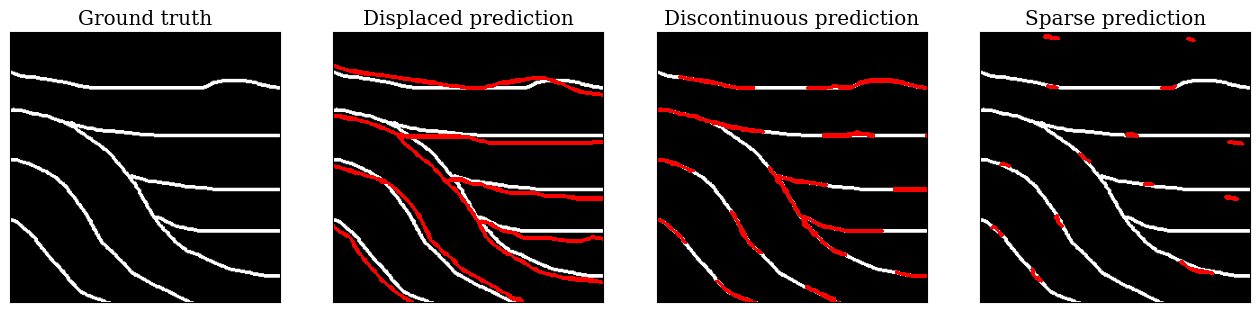

In [28]:
def convert_png_npy(img_file):
    label = Image.open(img_file).convert("L")
    label = np.array(label)
    label = np.where(label > 0, 0, 1)
    #label = np.abs(label - 1)
    #print(label.shape)
    np.save(img_file.replace('png', 'npy'), label)

convert_png_npy('test_imgs_dte/label.png')
convert_png_npy('test_imgs_dte/displaced.png')
convert_png_npy('test_imgs_dte/discontinuous.png')
convert_png_npy('test_imgs_dte/sparse.png')

label = np.load('test_imgs_dte/label.npy')
displaced = np.load('test_imgs_dte/displaced.npy')
discontinuous = np.load('test_imgs_dte/discontinuous.npy')
sparse = np.load('test_imgs_dte/sparse.npy')

# Plotar
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

label_plot = label.copy().astype(float)
#label_plot[label_plot == 0] = np.nan
axes[0].imshow(label_plot, cmap="gray")
axes[0].set_title('Ground truth')
# Remove ticks e labels, mas mantém a moldura
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])

displaced = dilation(displaced, disk(1))
displaced_plot = displaced.copy().astype(float)
displaced_plot[displaced_plot == 0] = np.nan
axes[1].imshow(label_plot, cmap="gray")
axes[1].imshow(displaced_plot, cmap="hsv", alpha=1)
axes[1].set_title('Displaced prediction')
# Remove ticks e labels, mas mantém a moldura
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])

discontinuous = dilation(discontinuous, disk(1))
discontinuous_plot = discontinuous.copy().astype(float)
discontinuous_plot[discontinuous_plot == 0] = np.nan
axes[2].imshow(label_plot, cmap="gray")
axes[2].imshow(discontinuous_plot, cmap="hsv", alpha=1)
axes[2].set_title('Discontinuous prediction')
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_xticklabels([])
axes[2].set_yticklabels([])

sparse = dilation(sparse, disk(1))
sparse_plot = sparse.copy().astype(float)
sparse_plot[sparse_plot == 0] = np.nan
axes[3].imshow(label_plot, cmap="gray")
axes[3].imshow(sparse_plot, cmap="hsv", alpha=1)
axes[3].set_title('Sparse prediction')
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_xticklabels([])
axes[3].set_yticklabels([])

plt.show()

# IMPORTANTE!!! Conversão para torch e formato esperado, para cálculo das métricas

label = torch.from_numpy(label)
label = torch.unsqueeze(label, dim=0)
label = torch.unsqueeze(label, dim=1)

displaced = torch.from_numpy(displaced)
displaced = torch.unsqueeze(displaced, dim=0)
displaced = torch.unsqueeze(displaced, dim=1)

discontinuous = torch.from_numpy(discontinuous)
discontinuous = torch.unsqueeze(discontinuous, dim=0)
discontinuous = torch.unsqueeze(discontinuous, dim=1)

sparse = torch.from_numpy(sparse)
sparse = torch.unsqueeze(sparse, dim=0)
sparse = torch.unsqueeze(sparse, dim=1)

In [5]:
def compute_dist_transform_error(targets_borders, predictions_borders, sigmoid=False):

    def get_distance_matrix(matrix):
        _, _, height, width = matrix.shape
        
        # Initialize distance matrix with max penalty
        penalty = torch.tensor(height).sum()
        dist_matrix = torch.ones_like(matrix).float() * penalty

        # Replace border values with zero
        pos_indices = torch.nonzero(matrix == 1, as_tuple=True)
        dist_matrix[pos_indices] = 0
        
        # Iterate over matrix rows to create distance mapping
        for index in range(1, height): 
            dist_matrix[:,:,index,:] = torch.min(dist_matrix[:,:,index,:], dist_matrix[:,:,index-1,:]+1)
        for index in reversed(range(0, height-1)): 
            dist_matrix[:,:,index,:] = torch.min(dist_matrix[:,:,index,:], dist_matrix[:,:,index+1,:]+1)
            
        return dist_matrix

    if sigmoid:
        predictions_borders = F.logsigmoid(predictions_borders).exp()
        predictions_borders = (predictions_borders > 0.5).to(torch.uint8)

    distance_matrix = get_distance_matrix(targets_borders)
    prediction_error = (distance_matrix * predictions_borders).sum() / distance_matrix.numel()
    return prediction_error.item()
    
    # DESCOMENTAR CASO SEJA DESEJADO ESCALAR A DISTÂNCIA COM BASE NO ERRO MÁXIMO. PORÉM NESSE CASO CONSIDERA TODOS OS PIXELS, NÃO APENAS ONDE 
    '''
    distance_matrix = get_distance_matrix(targets_borders)
    
    # IMPORTANTE! 
    # Caso na predição haja somente zeros onde deveria ser borda e vice-versa, o produto dessa predição com o ground truth é a distância máxima possível,
    # ou seja, o erro máximo. Nesse caso, essa medida tem a capacidade de regular a escala da métrica.   
    max_error = (distance_matrix  * torch.abs(1 - targets_borders)).sum() # torch.abs(1 - targets_borders) é a simulação da predição com erro máximo

    prediction_error = (distance_matrix * predictions_borders).sum()
    
    distance = prediction_error / max_error
    inverse_dist_error = 1 - distance.item()
    print(inverse_dist_error)
    '''

def binary_metrics(ground_truth_batch, output_batch, pixels_tolerance_for_metrics=0, sigmoid=False):

    if sigmoid:
        output_batch= F.logsigmoid(output_batch).exp()
        output_batch = (output_batch > 0.5).to(torch.uint8)

    #B, C, W, H = ground_truth_batch.shape

    # cálculo feito antes da conversão para numpy array, pois o cálculo da dist_transfor é feito em torch
    dist_pred_label = compute_dist_transform_error(ground_truth_batch, output_batch)
    dist_label_pred = compute_dist_transform_error(output_batch, ground_truth_batch)
    dist_transform_error = (dist_pred_label + dist_label_pred) / 2
    
    if isinstance(ground_truth_batch, torch.Tensor) or isinstance(output_batch, torch.Tensor):
        ground_truth_batch = ground_truth_batch.detach().cpu().numpy().squeeze(1)
        output_batch = output_batch.detach().cpu().numpy().squeeze(1)
    else:
        ground_truth_batch = ground_truth_batch.squeeze(1)
        output_batch = output_batch.squeeze(1)

    if pixels_tolerance_for_metrics > 0:
        dilated_ground_truth_batch = ground_truth_batch.copy()
        for i in range(dilated_ground_truth_batch.shape[0]):
            dilated_ground_truth_batch[i] = dilation(dilated_ground_truth_batch[i], disk(pixels_tolerance_for_metrics))
        dilated_ground_truth_batch = dilated_ground_truth_batch.ravel()
        
    ground_truth_batch = ground_truth_batch.ravel()
    output_batch = output_batch.ravel()

    if pixels_tolerance_for_metrics > 0:
        TP = np.sum((dilated_ground_truth_batch == 1) & (output_batch == 1))
    else:
        TP = np.sum((ground_truth_batch == 1) & (output_batch == 1))
    TN = np.sum((ground_truth_batch == 0) & (output_batch == 0))
    FP = np.sum((ground_truth_batch == 0) & (output_batch == 1))
    FN = np.sum((ground_truth_batch == 1) & (output_batch == 0))

    total = TP + TN + FP + FN
    accuracy = (TP + TN) / total if total != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    fallout = FP / (FP + TN) if (FP + TN) != 0 else 0
    iou = TP / (TP + FP + FN) if (TP + FP + FN) != 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    print(f'''{round(dist_transform_error, 3)}
{round(f1_score, 3)}
{round(precision, 3)}
{round(recall, 3)}
{round(iou, 3)}
{round(accuracy, 3)}\n'''.replace('\n', '\t').replace('.', ','))


In [29]:
'''
image = torch.randn([1, 1, 10, 10])
label = torch.zeros([1, 1, 10, 10], dtype=torch.long)

for idy in range(image.shape[2]):
    for idx in range(image.shape[3]):
        if idy > idx+1: label[:,:,idy,idx] = 1
        if idy < idx-1: label[:,:,idy,idx] = 1
label = torch.abs(label - 1).float()
worst_prediction = torch.abs(1 - label) # simulação do erro total, ou seja, a predição é o inverso da label

compute_dist_transform_error(label, image, sigmoid=True)
binary_metrics(label, image, sigmoid=True)
# compute_dist_transform_error(label, worst_prediction, sigmoid=False)
# compute_dist_transform_error(label, label, sigmoid=False)

'''

pixels_tolerance_for_metrics = 2

print("\nDisplaced\n")
dist_pred_label = compute_dist_transform_error(label, displaced, sigmoid=False)
dist_label_pred = compute_dist_transform_error(displaced, label, sigmoid=False)
mean_dist = (dist_pred_label + dist_label_pred) / 2
print('DTE prediction -> label: ', round(dist_pred_label, 3))
print('DTE label -> prediction: ', round(dist_label_pred, 3))
print('Mean DTE: ', round(mean_dist, 3))
binary_metrics(label, displaced, pixels_tolerance_for_metrics)

print("\nDiscontinuous\n")
dist_pred_label = compute_dist_transform_error(label, discontinuous, sigmoid=False)
dist_label_pred = compute_dist_transform_error(discontinuous, label, sigmoid=False)
mean_dist = (dist_pred_label + dist_label_pred) / 2
print('DTE prediction -> label: ', round(dist_pred_label, 3))
print('DTE label -> prediction: ', round(dist_label_pred, 3))
print('Mean DTE: ', round(mean_dist, 3))
binary_metrics(label, discontinuous, pixels_tolerance_for_metrics)

print("\nSparse\n")
dist_pred_label = compute_dist_transform_error(label, sparse, sigmoid=False)
dist_label_pred = compute_dist_transform_error(sparse, label, sigmoid=False)
mean_dist = (dist_pred_label + dist_label_pred) / 2
print('DTE prediction -> label: ', round(dist_pred_label, 3))
print('DTE label -> prediction: ', round(dist_label_pred, 3))
print('Mean DTE: ', round(mean_dist, 3))
binary_metrics(label, sparse, pixels_tolerance_for_metrics)


Displaced

DTE prediction -> label:  0.627
DTE label -> prediction:  0.379
Mean DTE:  0.503
0,503	0,202	0,172	0,243	0,112	0,843	

Discontinuous

DTE prediction -> label:  0.031
DTE label -> prediction:  1.708
Mean DTE:  0.87
0,87	0,727	0,742	0,713	0,571	0,951	

Sparse

DTE prediction -> label:  0.132
DTE label -> prediction:  10.536
Mean DTE:  5.334
5,334	0,239	0,547	0,153	0,136	0,927	
